In [1]:
# pip install open_clip_torch torch torchvision ftfy regex tqdm

import os
import torch
import open_clip
import numpy as np
from typing import Dict, List
import sys, os
sys.path.insert(0, os.path.abspath(".."))   # add parent to import path

from delyrism.ph import plot_symbols, run_topology_report, quantify_inter_symbol_PH, extract_symbol_cycles, extract_pair_cycles, plot_labeled_cycle  

import warnings
warnings.filterwarnings("ignore")

@torch.no_grad()
def get_clip_text_embeddings(
    symbol_to_words: Dict[str, List[str]],
    model_name: str = "ViT-B-32",          # ✅ correct OpenCLIP model id
    pretrained: str = "openai",            # e.g., "openai", "laion2b_s34b_b79k", "laion400m_e32"
    device: str = None,
    batch_size: int = 32,
    normalize: bool = True,
    save_csv_dir: str = None,              # e.g., "./embeddings_out"
) -> Dict[str, np.ndarray]:
    """
    Generate CLIP text embeddings for any number of words per symbol using OpenCLIP.

    Returns:
        dict: symbol -> numpy array of shape (num_words, embed_dim)
              (L2-normalized across rows if normalize=True)
    """
    # Pick device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load OpenCLIP model + tokenizer with a real pretrained checkpoint
    model, _, _ = open_clip.create_model_and_transforms(
        model_name, pretrained=pretrained, device=device
    )
    tokenizer = open_clip.get_tokenizer(model_name)
    model.eval()

    # Determine embedding dim safely
    if hasattr(model, "text_projection") and hasattr(model.text_projection, "shape"):
        embed_dim = model.text_projection.shape[1]
    elif hasattr(model, "embed_dim"):
        embed_dim = model.embed_dim
    else:
        # Fallback: will infer from first batch forward pass
        embed_dim = None

    out: Dict[str, np.ndarray] = {}

    # Create output dir if saving
    if save_csv_dir is not None:
        os.makedirs(save_csv_dir, exist_ok=True)

    for symbol, words in symbol_to_words.items():
        if len(words) == 0:
            if embed_dim is None:
                # If we haven't inferred embed_dim yet, set to 0 for empty
                out[symbol] = np.zeros((0, 0), dtype=np.float32)
            else:
                out[symbol] = np.zeros((0, embed_dim), dtype=np.float32)
            continue

        # Batched tokenization/encoding
        embs = []
        for i in range(0, len(words), batch_size):
            batch = words[i:i+batch_size]
            tokens = tokenizer(batch).to(device)              # (B, 77)
            text_features = model.encode_text(tokens)         # (B, D)

            if embed_dim is None:
                embed_dim = text_features.shape[1]            # infer once

            embs.append(text_features)

        embs = torch.cat(embs, dim=0)                         # (num_words, D)

        if normalize:
            embs = torch.nn.functional.normalize(embs, p=2, dim=1)

        arr = embs.detach().cpu().numpy().astype(np.float32)
        out[symbol] = arr

        # Optional: save CSV for each symbol (rows = words, cols = dims)
        if save_csv_dir is not None:
            np.savetxt(os.path.join(save_csv_dir, f"{symbol}.csv"), arr, delimiter=",")

    return out


# Provide exactly 10 words (or more/less) per symbol
symbols_to_words = {
    "Fire": [
        "fire","flame","spark","ember","blaze","inferno","torch","burn",
        "light","heat","energy","passion","destruction","phoenix","eruption","fury",
        "illumination","ignition","wildfire","transformation","scorch","smolder","pyre","candle",
        "lava","hellfire","incineration","kindle","glow","furnace","molten","sacrifice",
        "desire","rage","volcano","radiance","sun","forge","purification","alchemy",
        "fuel","sacred","trial","consumption","red","danger","warmth","vision",
        "resurrection","creative","zeal","courage"
    ],
    "Air": [
        "air","wind","breeze","gust","draft","current","oxygen","breath",
        "sky","atmosphere","cloud","whisper","freedom","spirit","song","flight",
        "storm","movement","invisible","ethereal","whirl","zephyr","hurricane","cyclone",
        "whirlwind","clarity","exhalation","inspiration","communication","thought","idea","voice",
        "sound","music","vibration","aether","exchange","space","expansion","messenger",
        "swift","stormy","howl","north","intellect","clarion","transience","weightless",
        "immaterial","dissolution","awakening","mind"
    ],
    "Water": [
        "water","river","ocean","rain","stream","lake","wave","current",
        "tide","spring","pool","flow","storm","ice","mist","dew",
        "purification","life","depth","fluidity","fountain","drop","flood","tsunami",
        "erosion","tears","healing","reflection","mirror","cleansing","nourishment","birth",
        "moisture","well","bay","delta","foam","brine","salt","drift",
        "submersion","immersion","stillness","ebb","undercurrent","change","dream","intuitive",
        "surrender","emotion"
    ],
    "Earth": [
        "earth","soil","ground","clay","stone","rock","mountain","valley",
        "field","forest","fertility","foundation","stability","harvest","terrain","cave",
        "root","body","material","nourishment","dust","plateau","boulder","sand",
        "minerals","ore","metal","weight","mass","strength","gravitas","endurance",
        "growth","life","germination","seed","crop","plain","hill","meadow",
        "nature","womb","abundance","protection","dwelling","ancestry","support","permanence",
        "matter","depth"
    ]
}



# Get embeddings (will be ~512-d for ViT-B-32)
embeddings_dict = get_clip_text_embeddings(
    symbols_to_words,
    model_name="ViT-B-32",        # ✅ correct name
    pretrained="openai",          # change to "laion2b_s34b_b79k" if you prefer LAION
    device=None,                  # auto-selects CUDA if available
    batch_size=32,
    normalize=True,
    save_csv_dir="./clip_symbol_embs"
)

# Inspect shapes
for sym, arr in embeddings_dict.items():
    print(sym, arr.shape)


c:\Users\skite\miniconda3\envs\delyrism\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fire (52, 512)
Air (52, 512)
Water (50, 512)
Earth (50, 512)


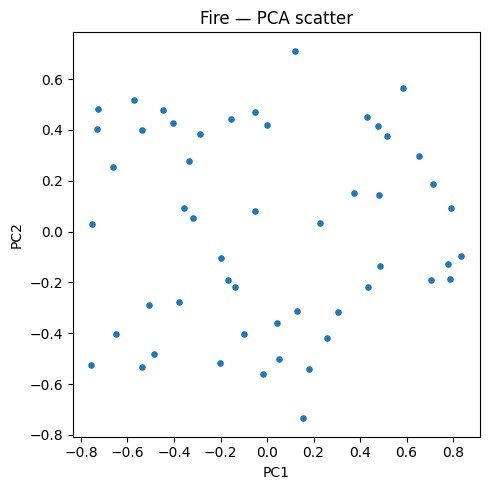

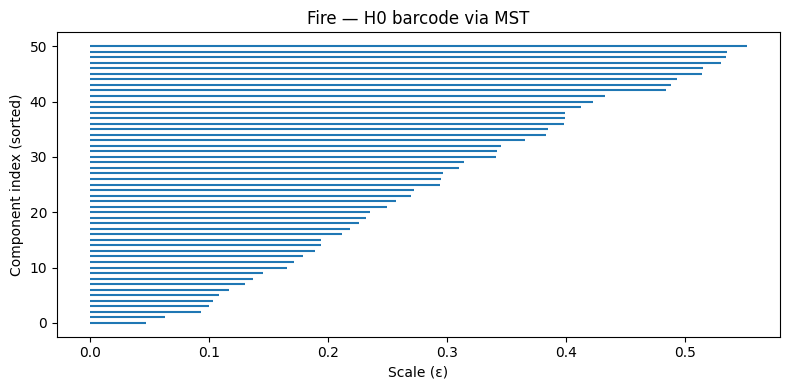

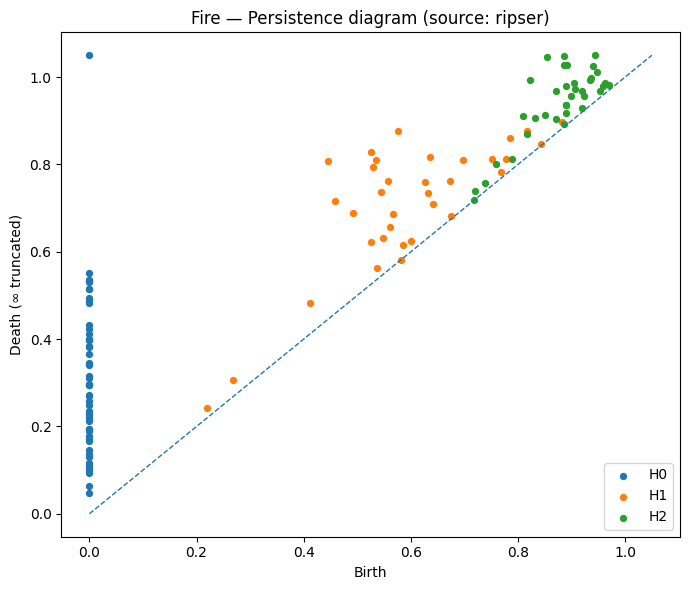

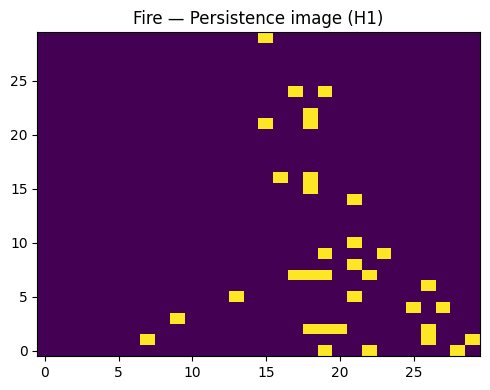

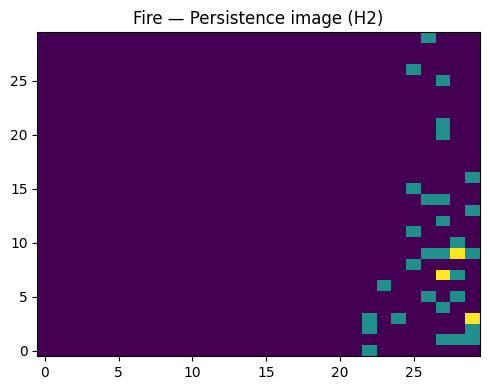

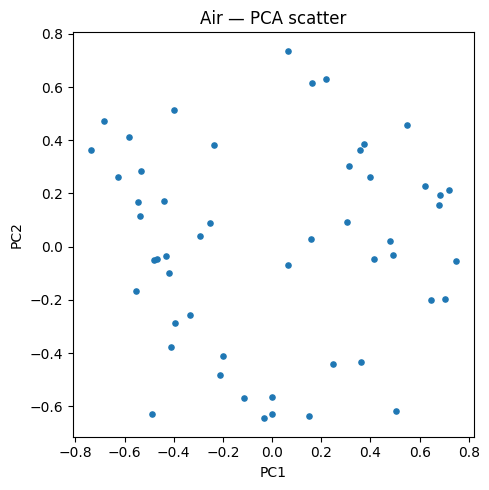

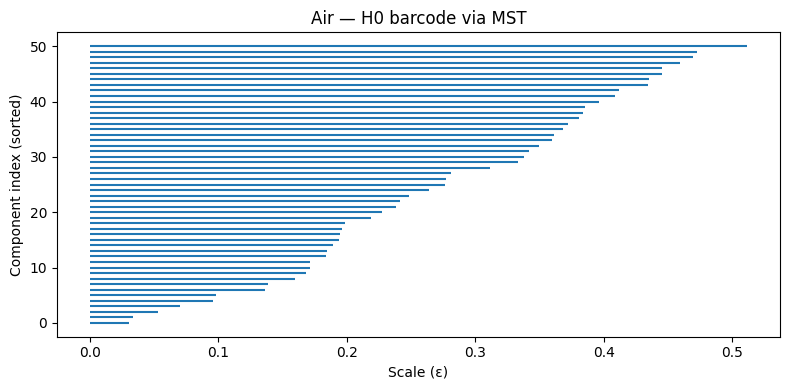

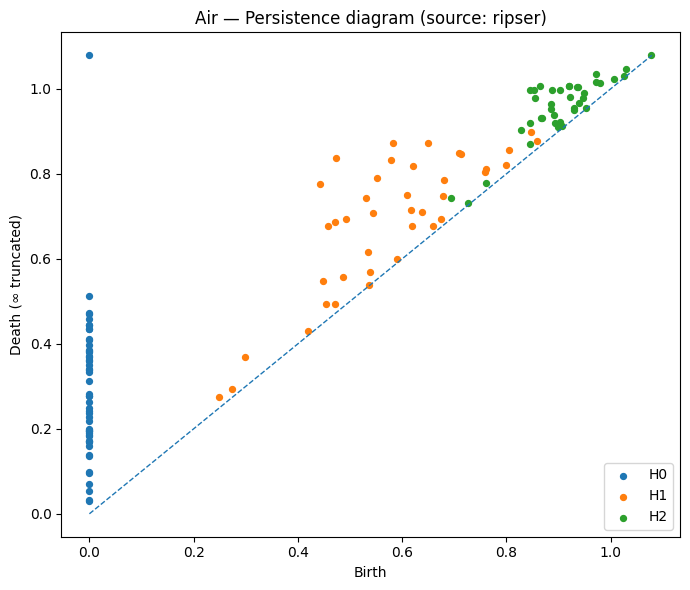

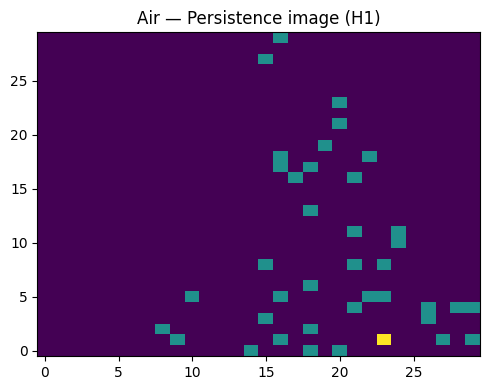

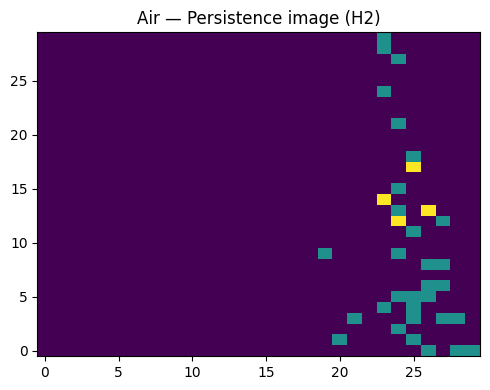

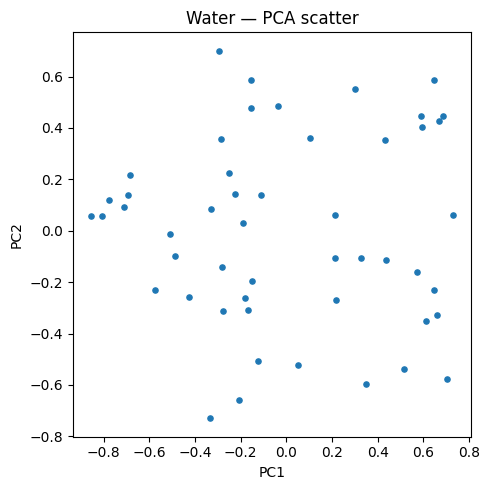

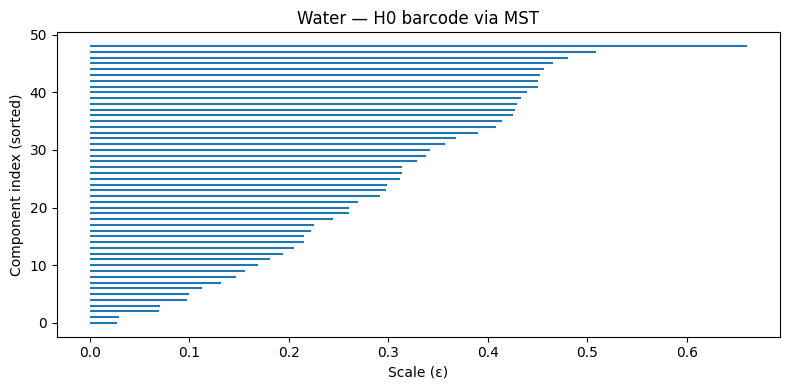

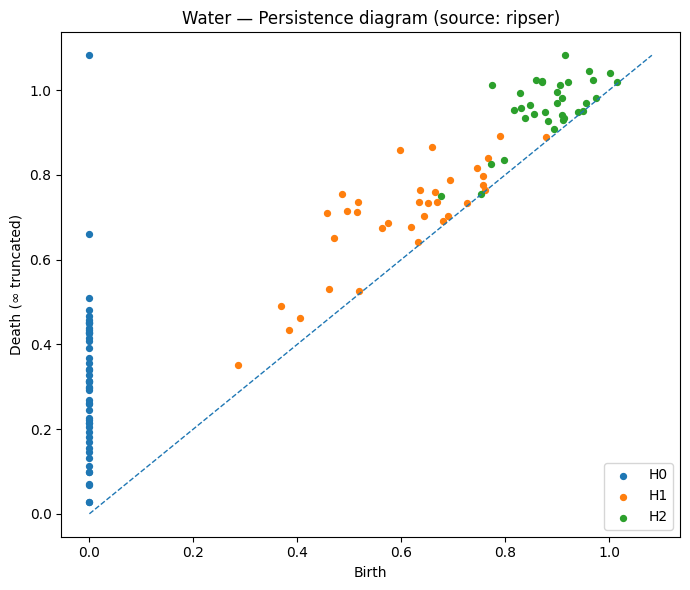

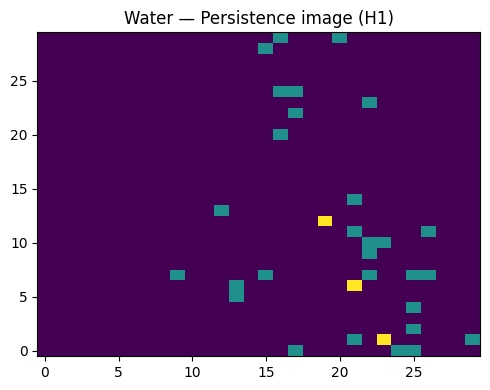

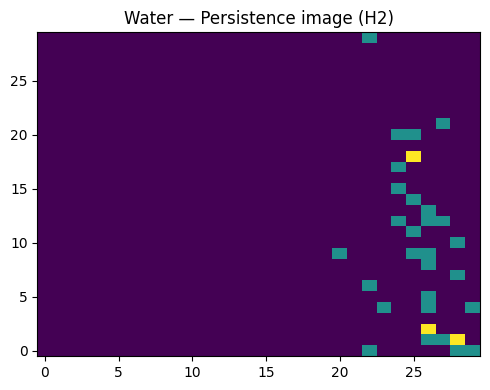

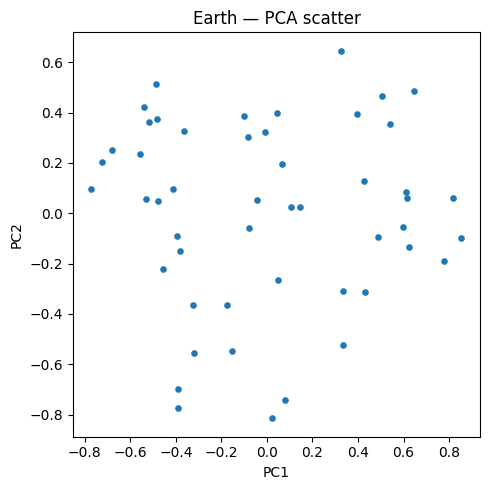

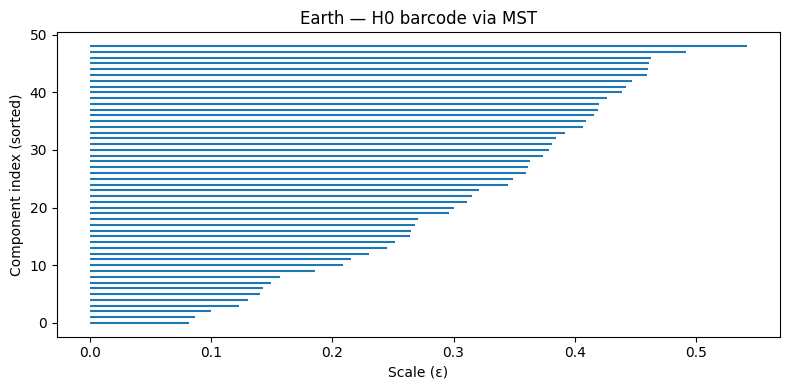

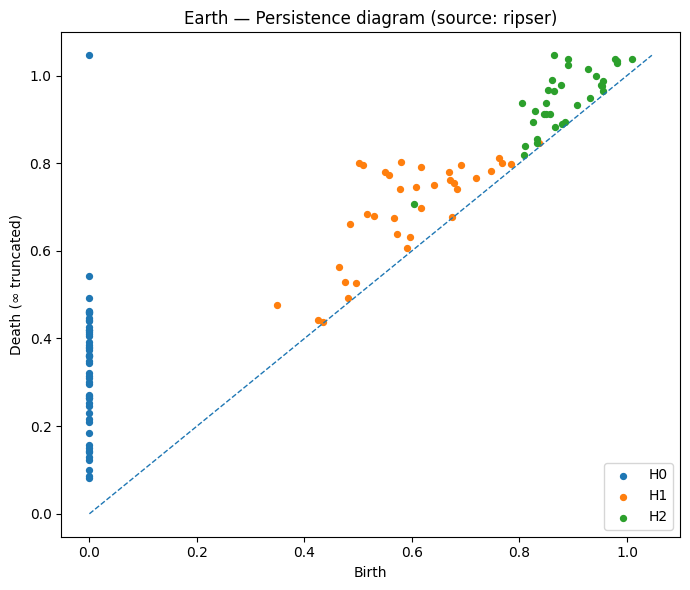

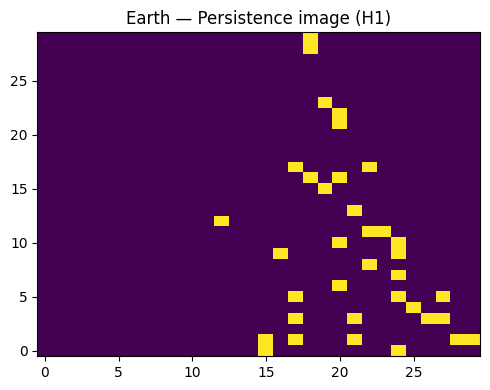

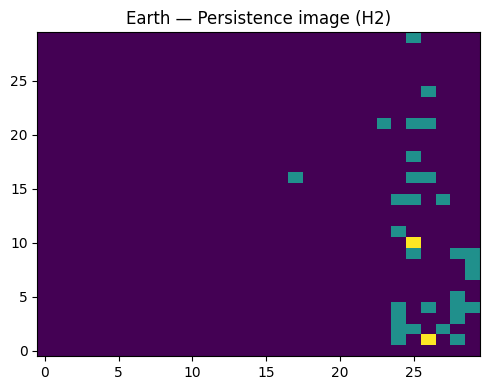

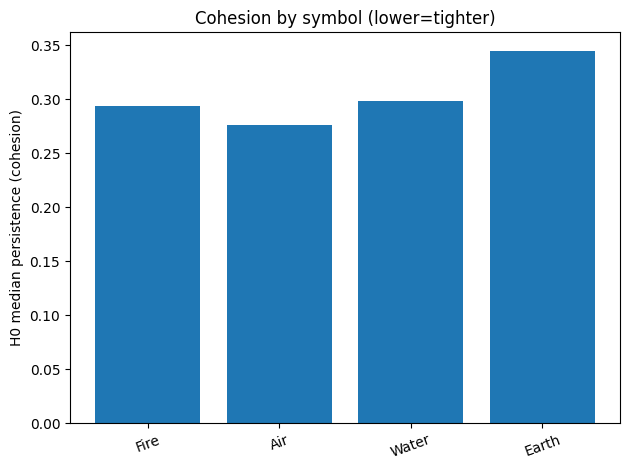

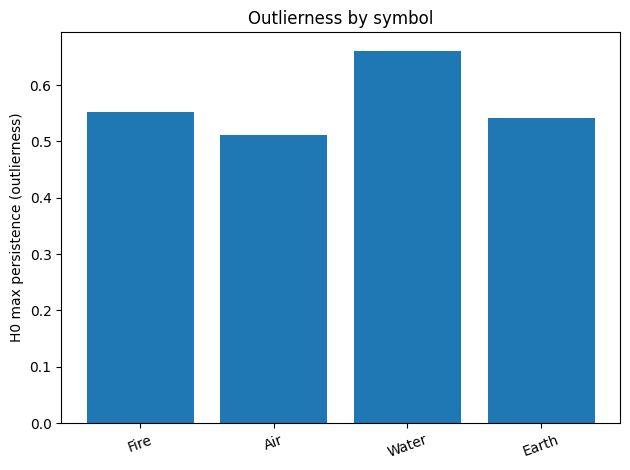

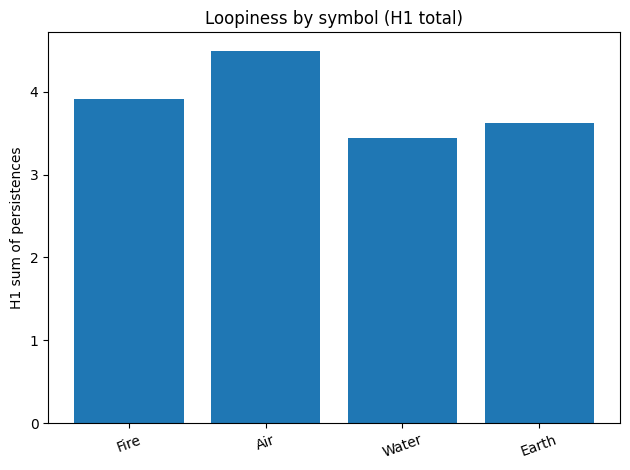

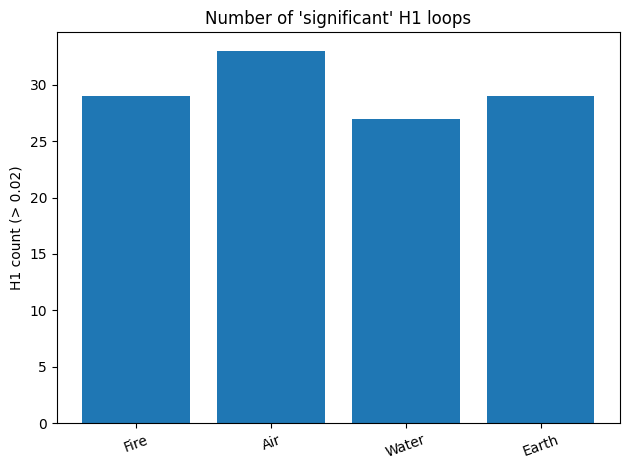

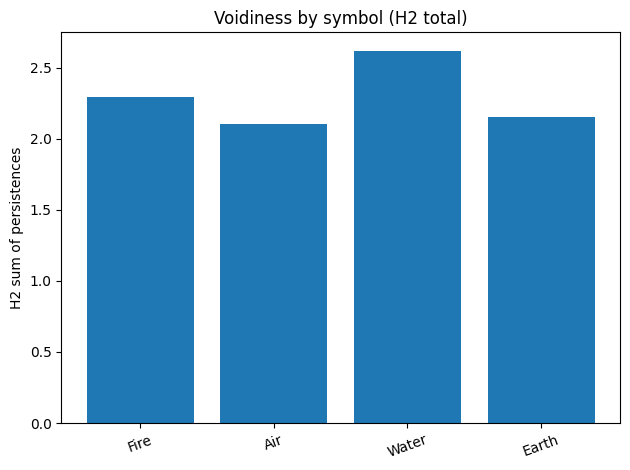

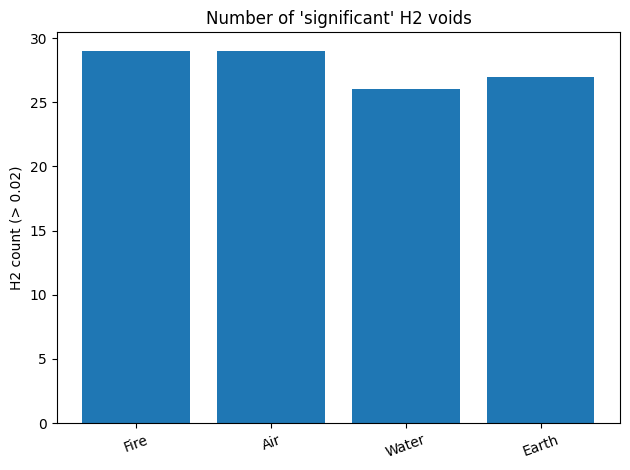

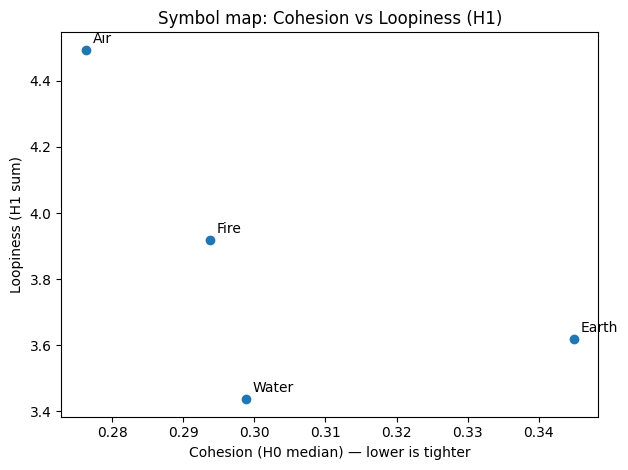

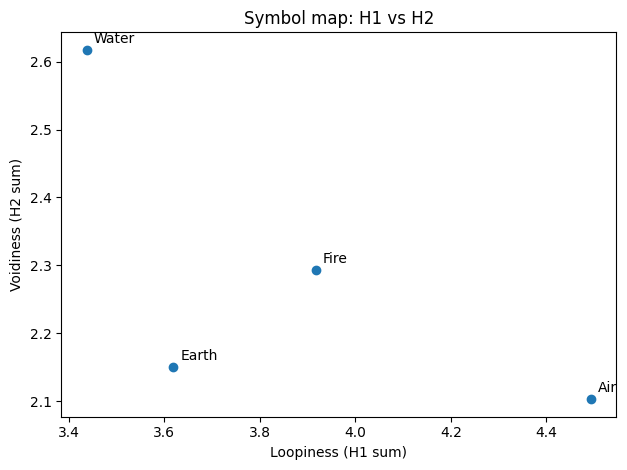

In [2]:
# Per-symbol diagnostics (PCA, H0 barcode, PD, H1 image)
summaries = plot_symbols(embeddings_dict, mode="per-symbol", metric="cosine")

# Cross-symbol comparison suite
_ = plot_symbols(embeddings_dict, mode="compare", metric="cosine", thr=0.02)


# Inter-symbol Synergy (All Pairs)

This table compares persistent-homology synergy between every pair of symbols using **cosine** distances.

**Columns**

- `sumH1_union` / `sumH2_union` — total finite persistence for H1 / H2 on the concatenated set A∪B.  
- `sumH1_no_cross` / `sumH2_no_cross` — same totals when **cross-symbol edges are disabled**.  
- `synergy_H1` / `synergy_H2` — how much loop/void structure **requires inter-symbol connections**: `union − no_cross`.  
  - Positive ⇒ topology emerges from interactions across the two symbols.

In [3]:
# 1) Table of inter-symbol synergy (all pairs)
df_pairs = quantify_inter_symbol_PH(embeddings_dict, metric="cosine")
print(df_pairs)
# Columns: pair, sumH1_union, sumH1_no_cross, synergy_H1, sumH2_union, sumH2_no_cross, synergy_H2


          pair  sumH1_union  sumH1_no_cross  synergy_H1  sumH2_union  \
2   Fire–Earth     0.099071        0.068178    0.030893     0.007967   
0     Fire–Air     0.071601        0.055038    0.016563     0.000492   
4    Air–Earth     0.080626        0.065526    0.015099     0.004147   
5  Water–Earth     0.070428        0.058133    0.012295     0.003603   
1   Fire–Water     0.043659        0.047644   -0.003985     0.000000   
3    Air–Water     0.038174        0.044992   -0.006818     0.000000   

   sumH2_no_cross  synergy_H2  
2        0.007969   -0.000002  
0        0.002804   -0.002312  
4        0.006148   -0.002001  
5        0.005657   -0.002053  
1        0.002312   -0.002312  
3        0.000492   -0.000492  


# Cycles Within **Water** (Cosine Metric)

Top persistent cycles found **within the “Water” symbol**.  
H1 indicates loop-like structure; H2 indicates void/cavity-like structure.


In [4]:
report = extract_symbol_cycles("Water", embeddings_dict["Water"], symbols_to_words["Water"], metric= 'cosine')
for cyc in report["H1"]:
    print("H1 loop:", cyc["persistence"], cyc["words"])
for cyc in report["H2"]:
    print("H2 void:", cyc["persistence"], cyc["words"])


H1 loop: 0.00926363468170166 ['submersion', 'ebb', 'undercurrent', 'surrender']
H1 loop: 0.003369748592376709 ['healing', 'cleansing', 'well']
H1 loop: 0.0018110871315002441 ['wave', 'tide']
H1 loop: 0.0015869140625 ['water', 'river', 'flood']
H1 loop: 0.0013952255249023438 ['submersion', 'undercurrent', 'surrender']


# Cycles Between **Water** and **Air** (Cosine Metric)

Top persistent cycles found **across the pair Water–Air**.  
Each cycle is annotated with its **mix type** (`pure_A`, `pure_B`, or `mixed`),  
its **dimension** (H1 loop or H2 void), persistence value, and participating words.

In [5]:
pair = extract_pair_cycles(
    embeddings_dict["Water"], symbols_to_words["Water"],
    embeddings_dict["Air"],   symbols_to_words["Air"],
)
for cyc in pair["H1"]:
    print(cyc["mix"], "H1", cyc["persistence"], cyc["words"])
for cyc in pair["H2"]:
    print(cyc["mix"], "H2", cyc["persistence"], cyc["words"])


pure_B H1 0.0188884437084198 ['breeze [B]', 'breath [B]']
mixed H1 0.01366358995437622 ['fluidity [A]', 'clarity [B]']
pure_B H1 0.011401772499084473 ['air [B]', 'freedom [B]', 'flight [B]', 'movement [B]', 'thought [B]']
pure_B H1 0.010126769542694092 ['breath [B]', 'exhalation [B]']
mixed H1 0.007092177867889404 ['current [A]', 'healing [A]', 'cleansing [A]', 'well [A]', 'dream [A]', 'current [B]', 'awakening [B]']
mixed H1 0.006385535001754761 ['intuitive [A]', 'emotion [A]', 'vibration [B]']


# Plot a labeled cycle within **Water**

Example: take the most persistent **H1 loop** inside Water,  
then plot its vertices with labels in PCA space.

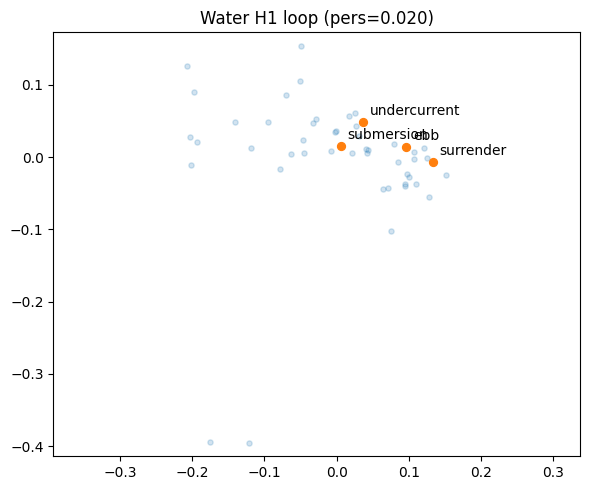

In [6]:
rep = extract_symbol_cycles("Water", embeddings_dict["Water"], symbols_to_words["Water"])
if rep["H1"]:
    cyc0 = rep["H1"][0]
    plot_labeled_cycle(embeddings_dict["Water"], symbols_to_words["Water"],
                       cyc0["vertex_ids"], title=f"Water H1 loop (pers={cyc0['persistence']:.3f})")


# Topology Report Example

The `run_topology_report` function generates a **persistent homology report** that combines per-symbol analysis, cross-symbol synergies, and word-level diagnostics.

## What it does

1. **Intrinsic topology per symbol**  
   - Computes cohesion (H0), loopiness (H1), and voidiness (H2).  
   - Aggregates these into a composite `TopoScore`.

2. **Shared topology (synergy centrality)**  
   - Measures how much persistent loops/voids depend on cross-symbol interactions.  
   - Produces synergy scores for each symbol and pair.

3. **Global rotated basis (PCA → Varimax)**  
   - Learns rotated components across all embeddings.  
   - Used for downstream component-level analysis.

4. **Component importance per symbol**  
   - Tests how removing components affects topology.  
   - Lists the most important components with RC+ and RC− words (positive vs negative ends).

5. **Word-level catalysts**  
   - **Leave-one-out (LOO):** shows which words are structurally critical for H1/H2.  
   - **Cycle participation:** shows words that appear most in persistent cycles.

At the end, a short **interpretive guide** explains how to read the results.

In [7]:
# Example run (Euclidean on row-normalized CLIP vectors; 20 rotated comps)
run_topology_report(
    embeddings_dict,
    symbols_to_words,
    metric="euclidean",
    n_components=20,
    top_components_show=3,
    top_words_show=6,
    top_words_loo=8,
    save_csv_dir=None  # or e.g. "./topology_report_out"
)



==================== TOPOLOGY REPORT ====================

1) Intrinsic topology per symbol
symbol  H0_cohesion   H1_sum   H2_sum  TopoScore
 Earth     0.411804 0.092212 0.012347   1.344656
   Air     0.394390 0.060268 0.001394   0.129428
  Fire     0.403510 0.068328 0.005444   0.038547
 Water     0.398452 0.042864 0.000000  -1.512630

2) Shared topology (synergy centrality)
symbol  synergy_H1  synergy_H2  SharedScore
 Earth    0.126710   -0.009323     2.410609
  Fire    0.105758   -0.011534    -0.177572
   Air    0.067758   -0.011084    -0.427313
 Water    0.002741   -0.011269    -1.805724

   Top pairs by H1 synergy:
       pair  synergy_H1  synergy_H2
 Fire–Earth    0.069123   -0.000645
   Fire–Air    0.043397   -0.005444
  Air–Earth    0.036223   -0.004246
Water–Earth    0.021365   -0.004431
 Fire–Water   -0.006762   -0.005444
  Air–Water   -0.011861   -0.001394

3) Building global rotated basis (PCA -> Varimax) for component analysis...
   Learned 20 rotated components.

4) Compo